In [30]:
import rasterio
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import csv

import fiona
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
from rasterio import windows as win
from statsmodels.formula.api import ols

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn import metrics


import io
from scipy import misc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

## set input addresses

In [31]:
lc_Address=r'Rasters\EU_LC_100.img'
tc_Address=r'Rasters\tc.img'
st_address=r'Rasters\st.img'
at_address=r'Rasters\airTemp.img'
eaa_raster_address=r'Rasters\EAA.img'
bldgSum_address = r'Rasters\bldgSum.tif'
eaa_vector_address=r'Vectors\RomeUrbanArea.shp'
dem_address= r'Rasters\dem.img'

In [32]:
def findWindow (shapeBound,mainRasterBnd,mainRasterCellSize):
    startRow = int((mainRasterBnd[3] - shapeBound[3])/mainRasterCellSize)
    endRow   = int((shapeBound[3] - shapeBound[1])/mainRasterCellSize)+1+startRow
    startCol = int((shapeBound[0] - mainRasterBnd[0])/mainRasterCellSize)
    endCol   = int((shapeBound[2] - shapeBound[0])/mainRasterCellSize)+1+startCol
    return (startRow,endRow,startCol,endCol)

In [33]:
with rasterio.open(tc_Address) as rst_tc:
            kwds = rst_tc.meta.copy()
            mainRasterBnd=rst_tc.bounds
            cellSize= kwds['transform'][0]

In [34]:
# name field from the eaa vector
nameField='URAU_NAME'
idField='EAA_ID'
countryCode='CNTR_CODE'
kbtuField='KBTU'

In [35]:
for pol in fiona.open(eaa_vector_address):
    #for pol in fiona.open(ecoAcAreasShapefile):
    eaa_name=(pol['properties'][nameField])
    eaa_country=(pol['properties'])[countryCode]
    eaa_id=(pol['properties'][idField])
    # kbtu per sq feet for residential use per year
    kbtu=(pol['properties'][kbtuField])
#     poly_Ycoor=(pol['properties']['Y_coor'])
    poly=(shape(pol['geometry']))
    #msaPoly=[shape(pol['geometry']) for pol in fiona.open(masShapeAddress)]

    with rasterio.open(tc_Address) as rst_tc:
        kwds = rst_tc.meta.copy()
        mainRasterBnd=rst_tc.bounds
        cellSize= kwds['transform'][0]

    polyBound = poly.bounds

    # create a window parameter tuple.   
    winProcessing=findWindow(polyBound,mainRasterBnd,cellSize)
    #(row_start, row_stop), (col_start, col_stop)
    window_use=((winProcessing[0],winProcessing[1]),(winProcessing[2],winProcessing[3]))

    # set the cells that do not have the city id as np.nan. This way we are getting cells insdie the boundary only.
    with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        eaaAr=eaaAr.flatten()
        
    with rasterio.open(tc_Address) as rst_tc:
        tc_ar=rst_tc.read(1, window=window_use)
        tcNoData = (rst_tc.meta.copy())['nodata']
        tc_ar=tc_ar.astype('float')
        #nlcd_tc_win_ar[eaaAr!=eaa_id]=np.nan
        tc_ar=tc_ar.flatten()
        kwds = rst_tc.meta.copy()
        #print ('got the nlcd-tc layer')

    with rasterio.open(lc_Address) as src:
        lc_ar=src.read(1, window=window_use)
        lcNoData = (src.meta.copy())['nodata']
        lc_ar=lc_ar.astype('float')
        #nlcd_lc[eaaAr!=eaa_id]=np.nan
        lc_ar=lc_ar.flatten()
        #print('got the nlcd-lc layer')

    with rasterio.open(st_address) as src:
        st=src.read(1, window=window_use)
        stNoData = (src.meta.copy())['nodata']
        st=st.astype('float')
        st=st.flatten()
        
    with rasterio.open(at_address) as src:
        at=src.read(1, window=window_use)
        atNoData = (src.meta.copy())['nodata']
        at=at.astype('float')
        at=at.flatten()
        
    with rasterio.open(dem_address) as src:
        dem=src.read(1, window=window_use)
        demNoData = (src.meta.copy())['nodata']
        dem=dem.astype('float')
        dem=dem.flatten()
    
    with rasterio.open(bldgSum_address) as src:
        bldgSum = src.read(1,window=window_use)
        bldgNodata = (src.meta.copy())['nodata']
        bldgSum = bldgSum.astype('float')
        bldgSum = bldgSum.flatten()
        
    allArrays=np.dstack((tc_ar,lc_ar,st,at,eaaAr,bldgSum,dem))
    allArrays=allArrays[0,:,:]

    df=pd.DataFrame(allArrays,columns=['tc','lc','st','at','eaaAr','bldgSum','elevation'])

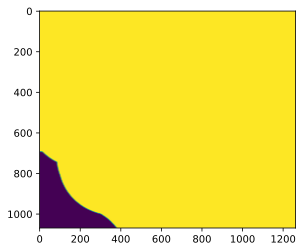

In [36]:
ar_test = np.array(df.elevation)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

In [37]:
df.sample(10)

tc       lc       st       at  eaaAr  bldgSum     elevation
59843      0.0    211.0   4453.0   2994.0    0.0      0.0  3.700000e+01
1138461  255.0 -32768.0  65535.0  65535.0    0.0      0.0 -2.147484e+09
1198455    0.0    242.0   4121.0   2990.0    0.0      0.0  4.500000e+01
53502     84.0    223.0   4151.0   2992.0    0.0      0.0  9.200000e+01
1226497   51.0    223.0   3749.0   2971.0    0.0      0.0  3.160000e+02
874953     0.0    124.0   4186.0   2996.0    1.0      0.0  1.000000e+00
908446     0.0    211.0   4613.0   2981.0    0.0      0.0  2.010000e+02
981038     0.0    211.0   4178.0   2994.0    1.0      0.0  5.000000e+00
387014    89.0    311.0   3189.0   2948.0    1.0      0.0  8.870000e+02
153986     0.0    211.0   4296.0   2991.0    0.0      0.0  4.400000e+01

In [38]:
# filter nodata values
df = df[(df['st']!=stNoData)&
        (df['at']!=atNoData)&
        (df['lc']!=lcNoData)&
        (df['tc']!=tcNoData)&
        (df['eaaAr']!=eaaNoData)&
        (df['bldgSum']!=bldgNodata)&
        (df['elevation']!=demNoData)
       ]

In [39]:
# convert the values to the correct units
df['st']=df['st']/100;
df['at']=df['at']/100;
df['bldgSum']=df['bldgSum']/100;

In [42]:
df.elevation.mean()

294.7789056371494

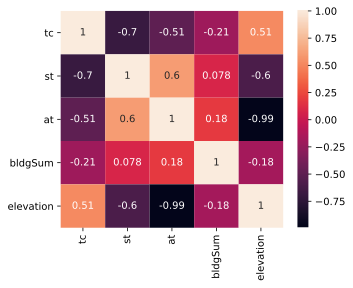

In [26]:
# plot corrolations
plt.figure(figsize=(5,4))
sns.heatmap(((df[['tc','st','at','bldgSum','elevation']]).corr()), annot=True)

## This is a simple linear regression

In [28]:
features_airModel = ['elevation']
depVar_airModel = df['at']
indepVar_airModel = sm.add_constant(df[features_airModel],has_constant='add')
# Fit and summarize OLS model
airModel = sm.OLS(depVar_airModel, indepVar_airModel)
results_airModel = airModel.fit()
print(results_airModel.summary())
## for prediction the following code will be used:
predict_airModel = results_airModel.get_prediction(indepVar_airModel)
predict_airModel = predict_airModel.summary_frame(alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:                     at   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 4.446e+07
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        20:39:50   Log-Likelihood:             1.4081e+06
No. Observations:              615719   AIC:                        -2.816e+06
Df Residuals:                  615717   BIC:                        -2.816e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.9605   4.28e-05      7e+05      0.0

In [29]:
features_airModel = ['tc']
depVar_airModel = df['st']
indepVar_airModel = sm.add_constant(df[features_airModel],has_constant='add')
# Fit and summarize OLS model
airModel = sm.OLS(depVar_airModel, indepVar_airModel)
results_airModel = airModel.fit()
print(results_airModel.summary())
## for prediction the following code will be used:
predict_airModel = results_airModel.get_prediction(indepVar_airModel)
predict_airModel = predict_airModel.summary_frame(alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 5.774e+05
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        20:45:43   Log-Likelihood:            -1.6166e+06
No. Observations:              615719   AIC:                         3.233e+06
Df Residuals:                  615717   BIC:                         3.233e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.5411      0.006   7751.048      0.0

In [14]:
predict_airModel.sample(10)

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
631342  43.541140  0.005617      43.530130      43.552150     36.990656   
629204  43.541140  0.005617      43.530130      43.552150     36.990656   
698398  37.200845  0.006329      37.188440      37.213250     30.650359   
902073  40.282933  0.004305      40.274495      40.291370     33.732453   
82627   38.609800  0.005112      38.599780      38.619819     32.059317   
692338  43.541140  0.005617      43.530130      43.552150     36.990656   
508828  43.541140  0.005617      43.530130      43.552150     36.990656   
723922  43.541140  0.005617      43.530130      43.552150     36.990656   
761342  43.541140  0.005617      43.530130      43.552150     36.990656   
622899  43.541140  0.005617      43.530130      43.552150     36.990656   

        obs_ci_upper  
631342     50.091624  
629204     50.091624  
698398     43.751331  
902073     46.833413  
82627      45.160282  
692338     50.091624  
508828     50.091624  
723922     50.091624  
761342     50.091624  
622899     50.091624